In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /home/cvk/mmocr/
!ls

import cv2
import math
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
from mmocr.utils.ocr import MMOCR
from sklearn.cluster import KMeans
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression

from IPython.display import display, HTML
import pandas as pd
%matplotlib inline

1.7.0+cu110 True
2.18.0
1.3.17
11.0
GCC 7.3
0.3.0
/home/cvk/mmocr
 CITATION.cff			 model-index.yml
 configs			 outputs
 data				 README.md
 demo				 README_zh-CN.md
 docker				 requirements
 docs				 requirements.txt
 docs_zh_CN			 resources
 edges-50-150.jpg		 result.csv
 example1.pdf			 result.png
 example2.pdf			 setup.cfg
 example.pdf			 setup.py
 Final_round_mmocr-Copy1.ipynb	 TableOCR.ipynb
 Final_round_mmocr-Copy2.ipynb	'TableWithGridLayoutOCR 1.01.ipynb'
 Final_round_mmocr-Copy3.ipynb	 test1.csv
 Final_round_mmocr-Copy4.ipynb	 test.csv
 Final_round_mmocr.ipynb	 test.png
 INFO				 tests
 LastTry.ipynb			 tools
 LICENSE			 t.png
 loverBoy.ipynb			 Untitled1.ipynb
 loverCode.ipynb		 Untitled2.ipynb
 MANIFEST.in			 Untitled.ipynb
 mmocr				 wget-log
 mmocr_demo.ipynb		 wildreceipt.tar


In [2]:
import numpy as np
import pdf2image
import cv2

In [3]:
def convert_pdf_to_image(document, dpi):
    images = []
    images.extend(
                    list(
                        map(
                            lambda image: cv2.cvtColor(
                                np.asarray(image), code=cv2.COLOR_RGB2BGR
                            ),
                            pdf2image.convert_from_path(document, dpi=dpi),
                        )
                    )
                )
    return images

In [4]:
images = convert_pdf_to_image('example1.pdf',300)

In [5]:
print(len(images))

1


In [6]:
print(images[0].shape)

(3508, 2481, 3)


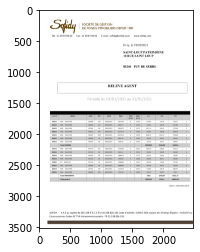

In [7]:
first_page = images[0]
plt.imshow(first_page)

In [8]:
# Constants
lineBreak = '\n'

In [9]:
image = first_page
result = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


# Detect horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=4)
cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Create a list of y=value line
yLines = []
for c in cnts:
    if len(c) > 3:
        yLines.append(c[0][0][1])

# Detect vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,10))
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=4)
cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]


# Create a list of x=value line
xLines=[]
for c in cnts:
    if len(c) > 3:
        xLines.append(c[0][0][0])
cv2.imwrite("result.png", result)

xLines.sort()
yLines.sort()
#Filter duplicates lines in xLines
tmp = []
for x in xLines:
    if len(tmp) > 0 and x >= tmp[-1] + 5:
        tmp.append(x)
    elif len(tmp) == 0:
        tmp.append(x)
xLines = tmp
#Filter duplicates lines in yLines
tmp = []
for y in yLines:
    if len(tmp) > 0 and y >= tmp[-1] + 5:
        tmp.append(y)
    elif len(tmp) == 0:
        tmp.append(y)
        
yLines = tmp

In [10]:
print(len(xLines))
print(len(yLines))

25
23


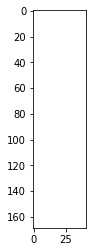

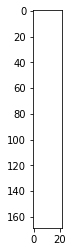

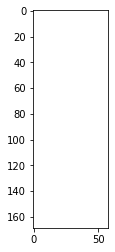

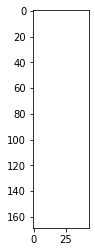

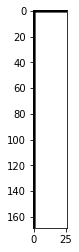

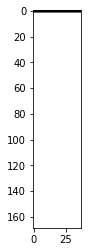

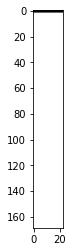

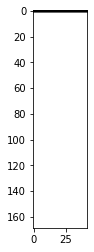

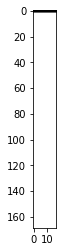

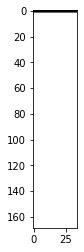

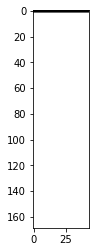

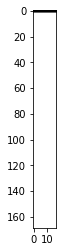

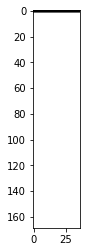

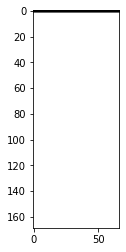

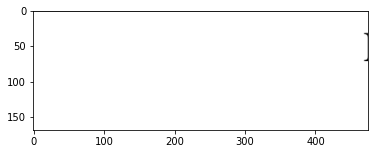

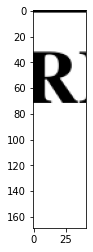

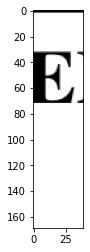

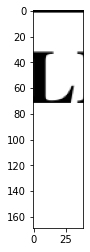

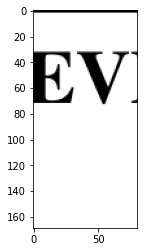

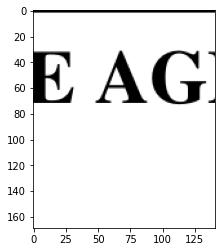

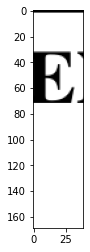

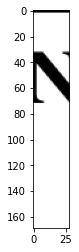

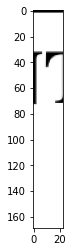

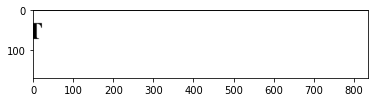

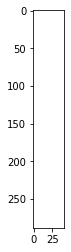

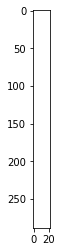

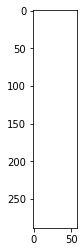

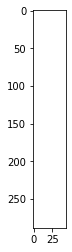

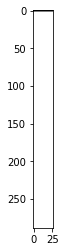

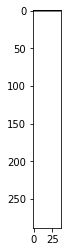

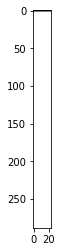

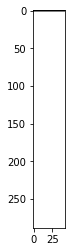

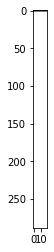

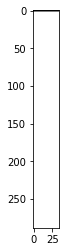

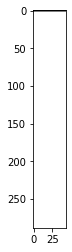

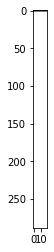

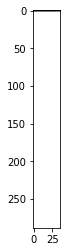

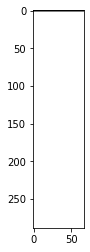

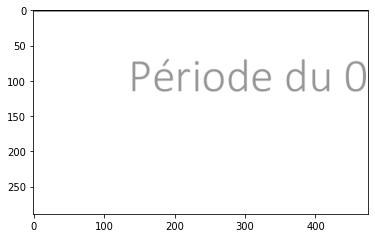

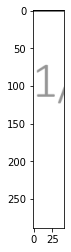

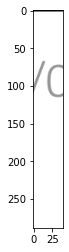

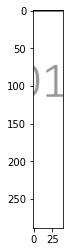

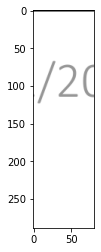

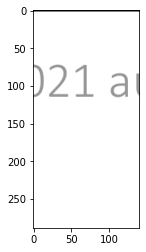

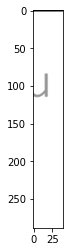

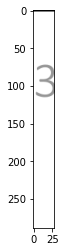

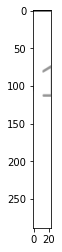

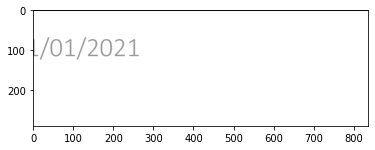

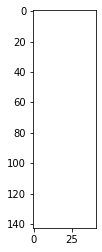

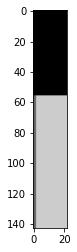

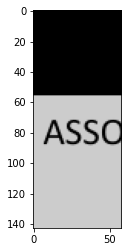

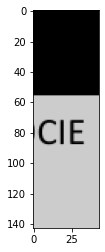

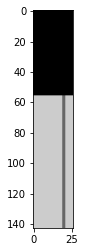

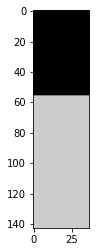

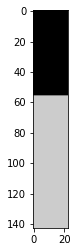

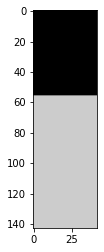

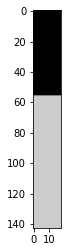

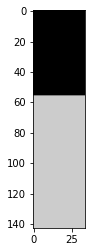

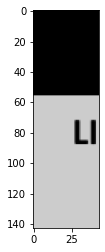

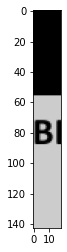

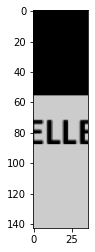

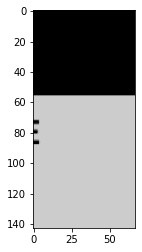

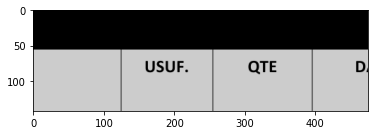

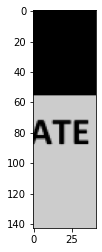

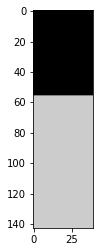

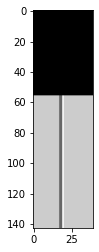

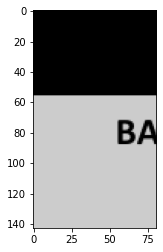

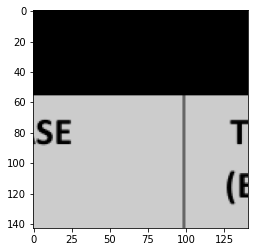

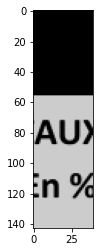

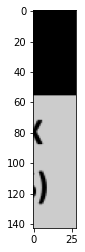

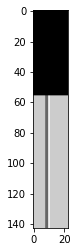

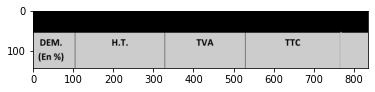

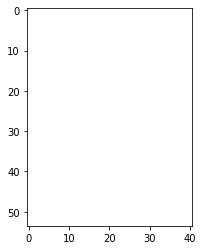

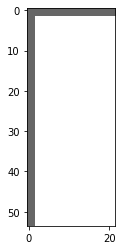

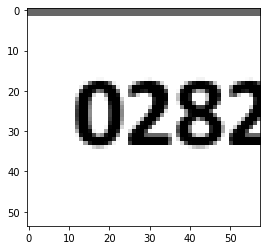

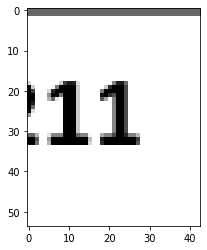

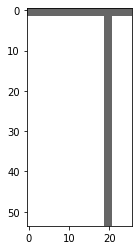

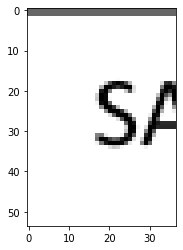

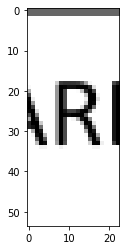

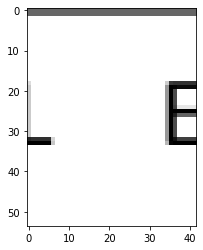

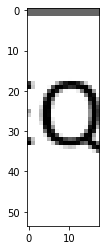

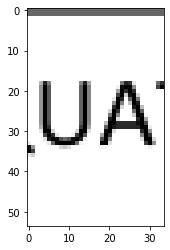

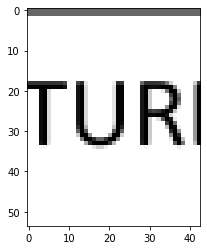

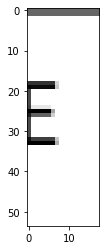

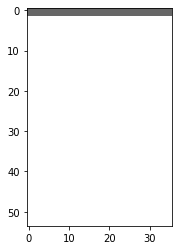

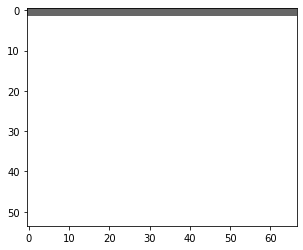

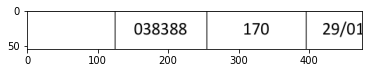

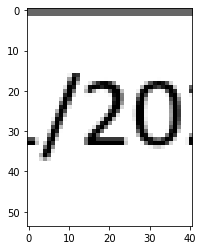

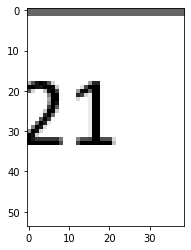

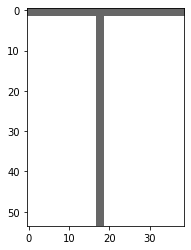

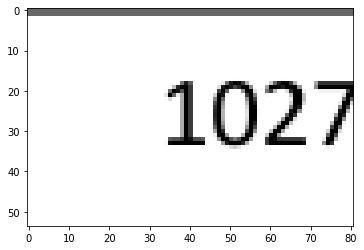

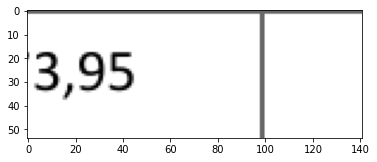

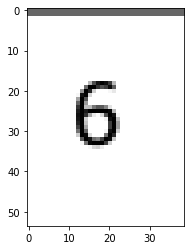

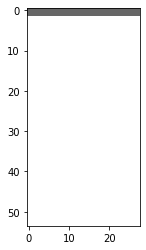

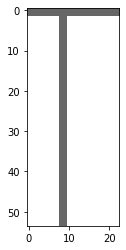

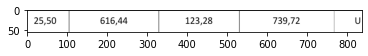

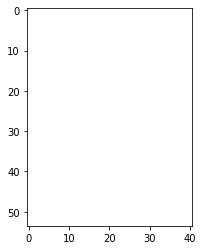

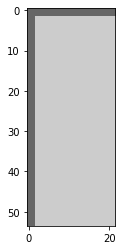

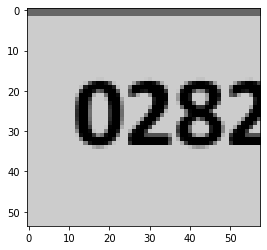

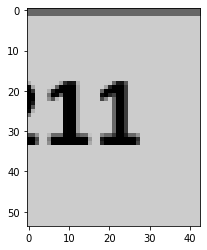

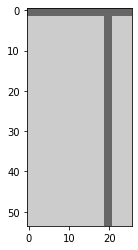

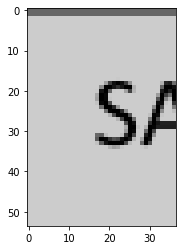

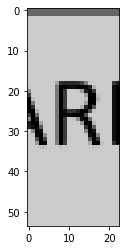

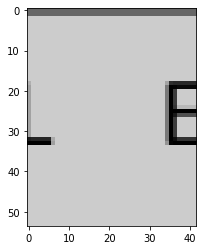

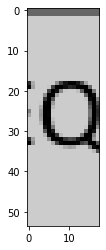

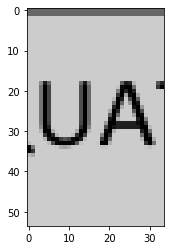

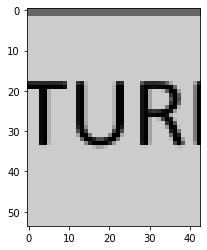

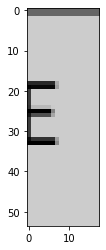

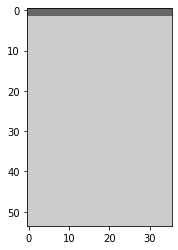

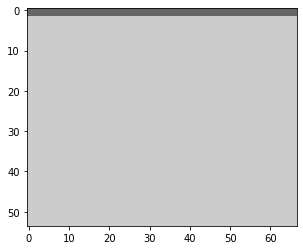

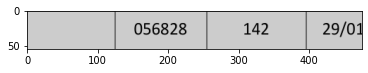

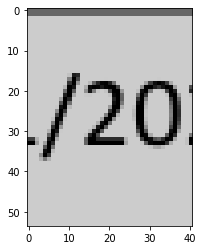

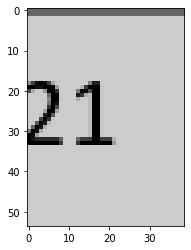

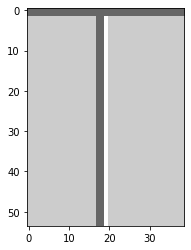

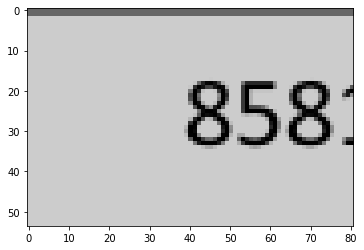

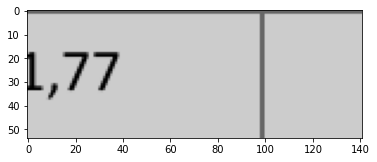

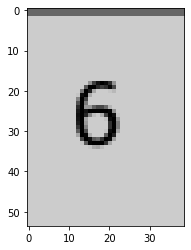

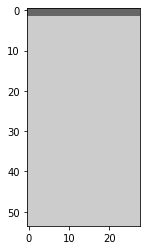

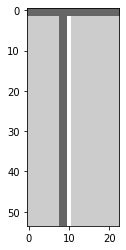

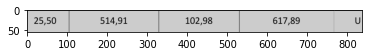

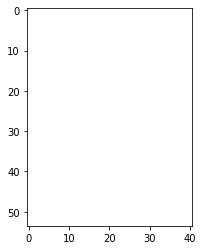

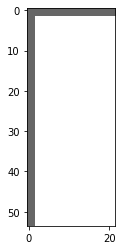

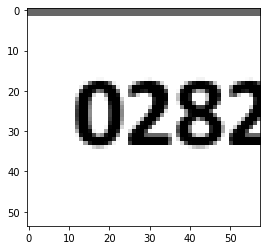

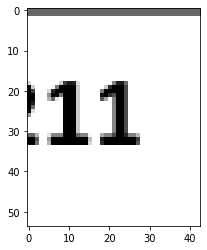

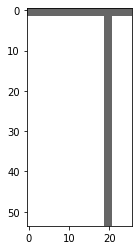

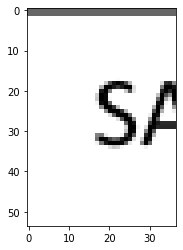

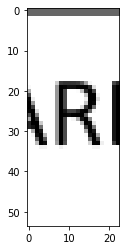

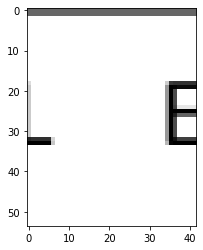

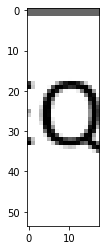

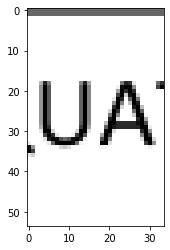

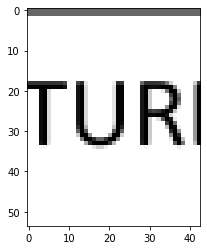

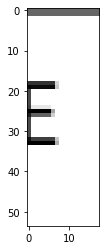

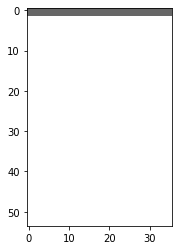

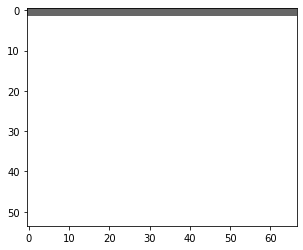

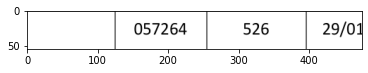

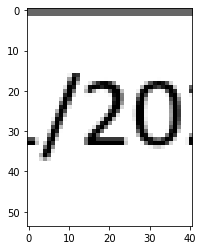

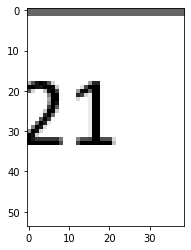

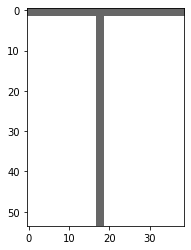

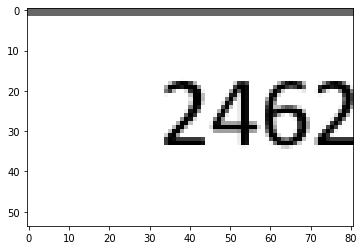

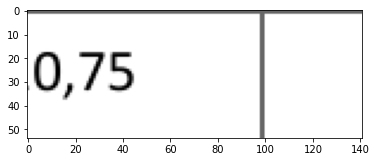

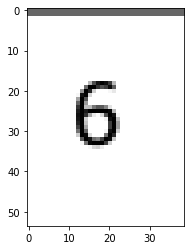

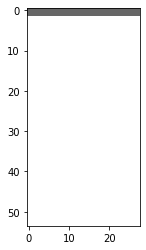

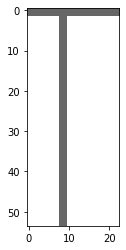

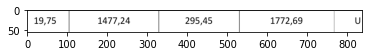

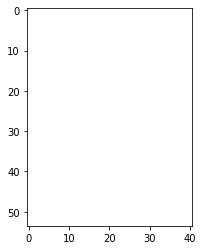

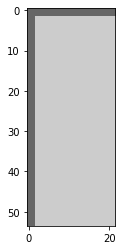

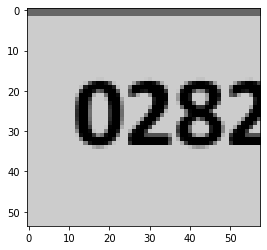

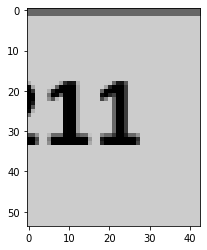

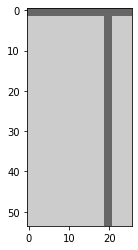

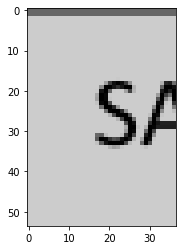

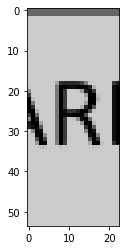

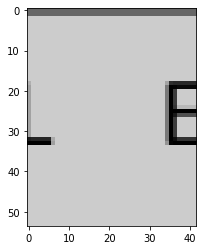

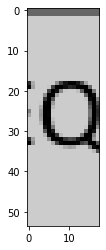

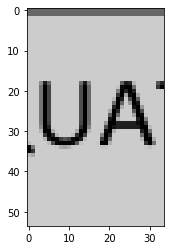

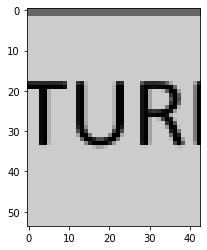

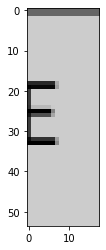

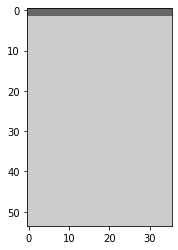

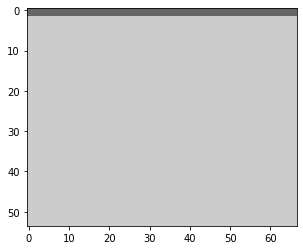

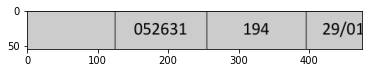

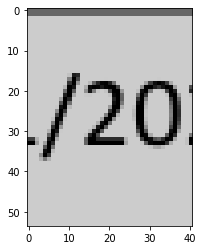

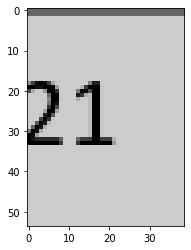

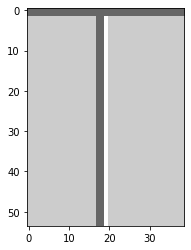

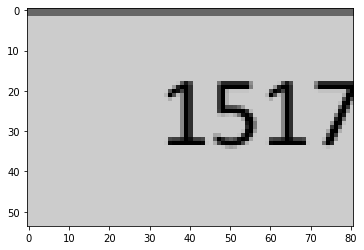

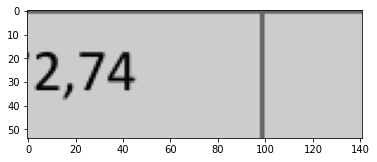

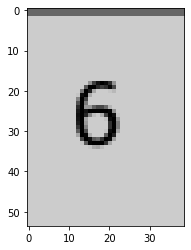

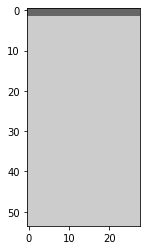

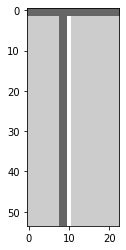

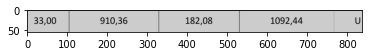

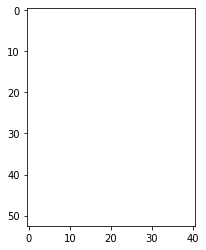

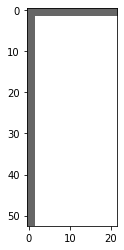

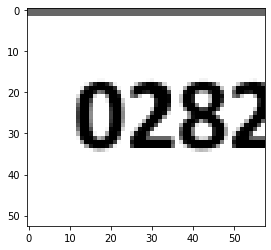

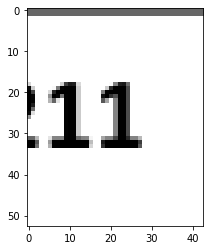

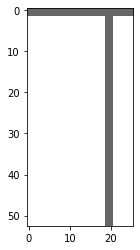

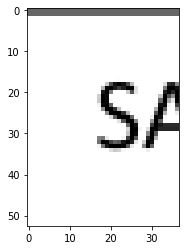

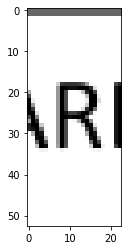

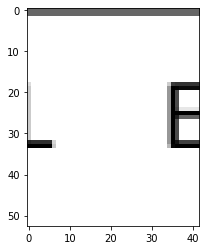

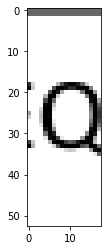

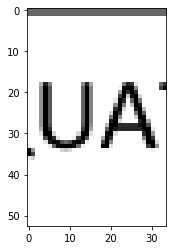

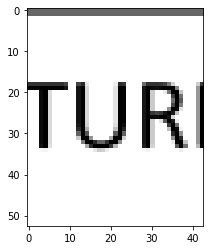

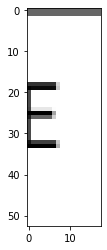

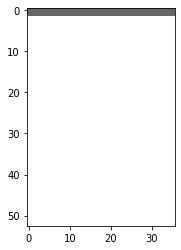

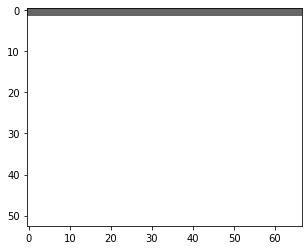

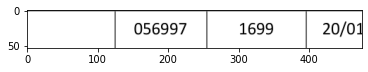

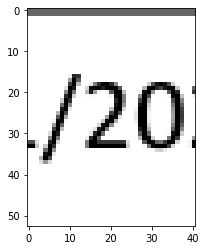

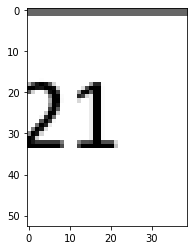

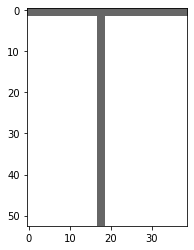

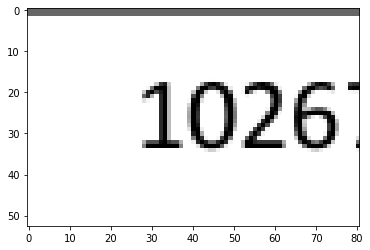

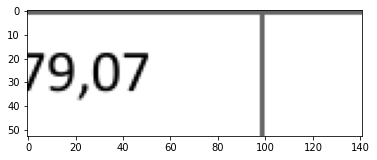

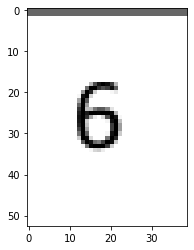

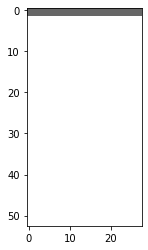

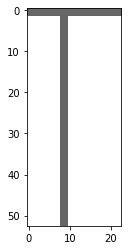

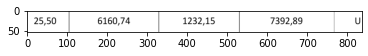

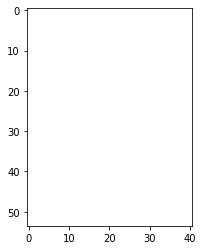

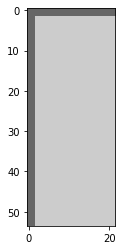

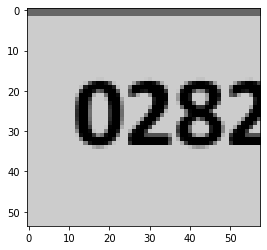

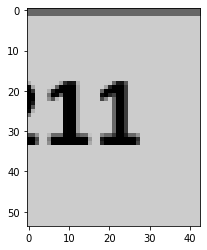

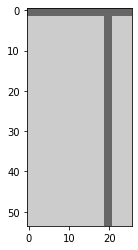

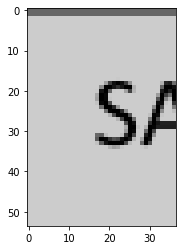

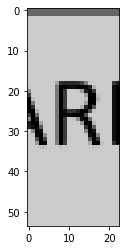

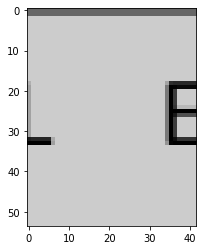

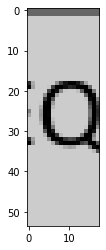

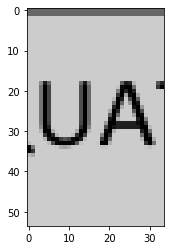

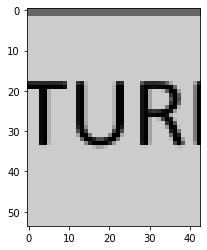

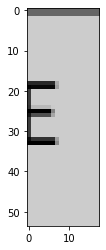

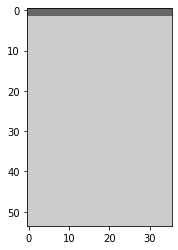

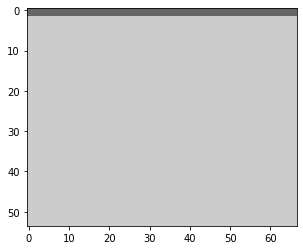

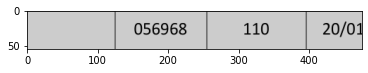

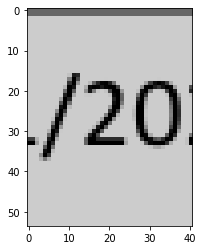

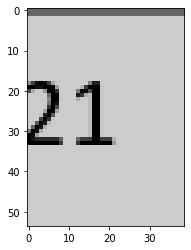

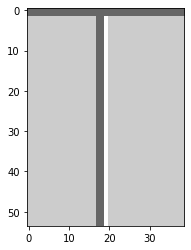

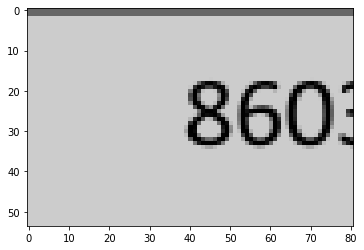

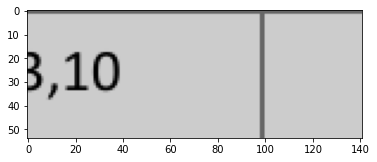

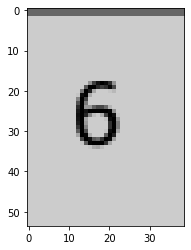

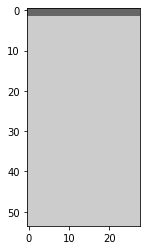

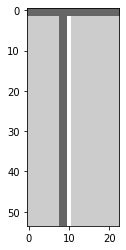

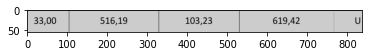

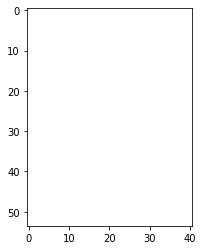

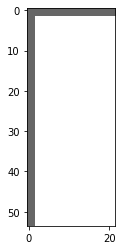

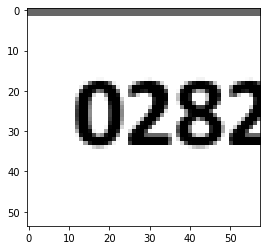

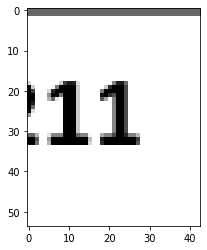

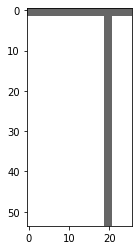

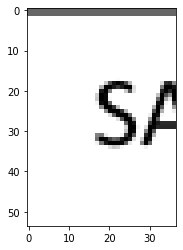

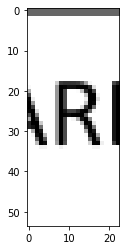

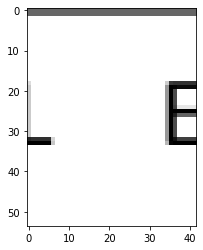

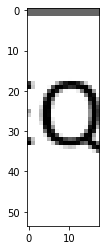

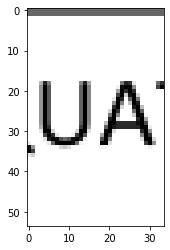

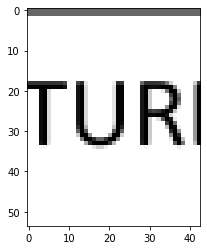

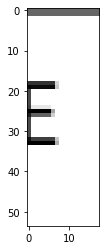

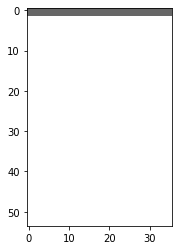

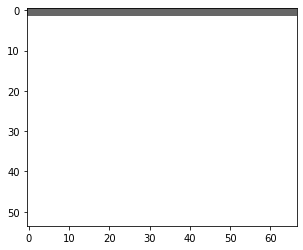

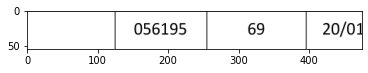

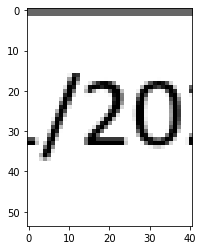

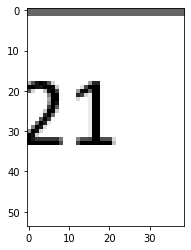

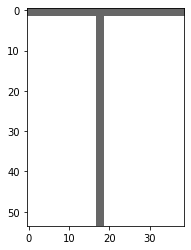

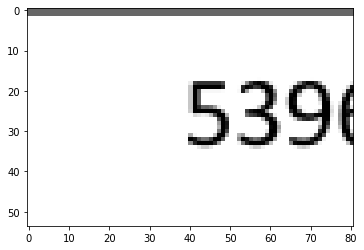

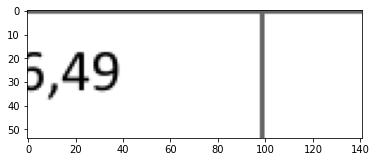

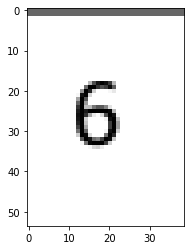

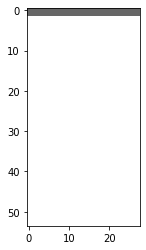

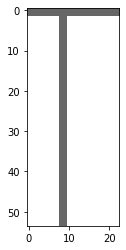

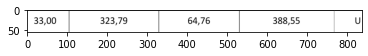

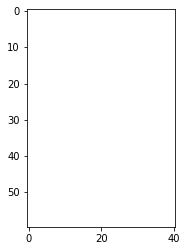

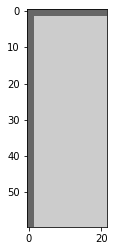

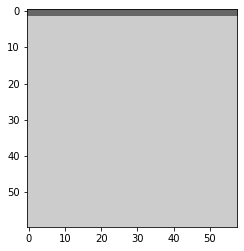

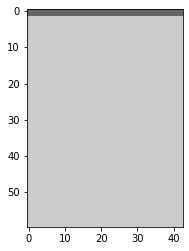

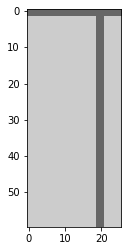

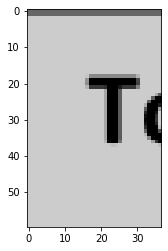

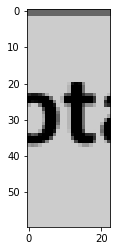

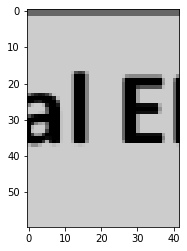

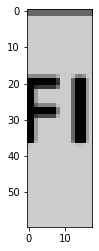

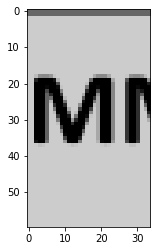

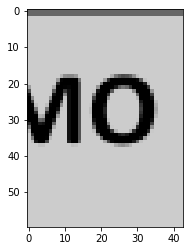

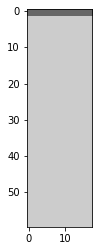

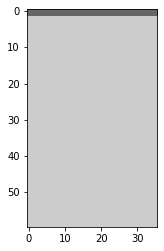

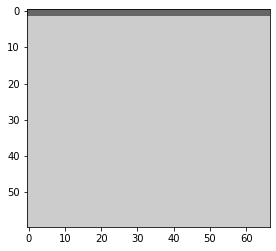

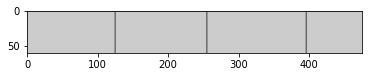

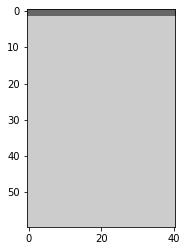

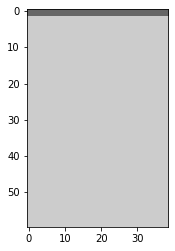

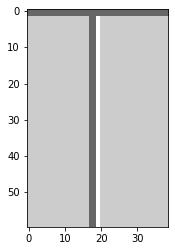

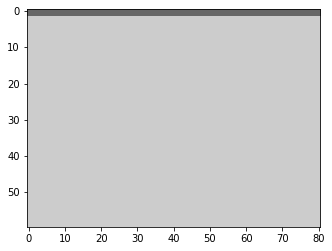

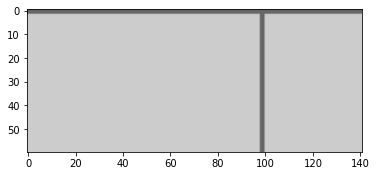

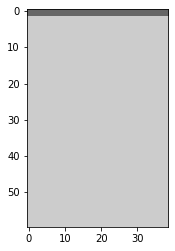

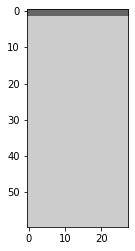

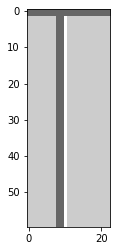

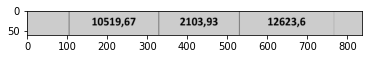

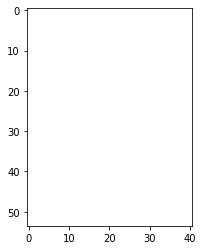

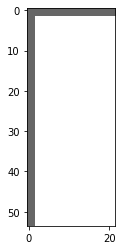

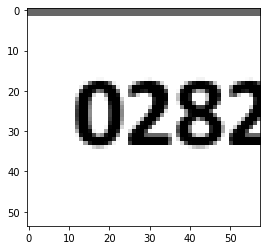

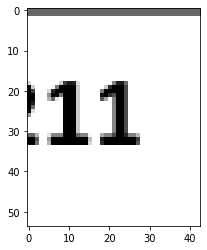

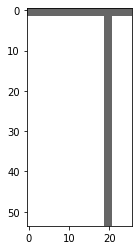

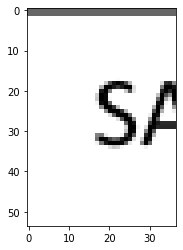

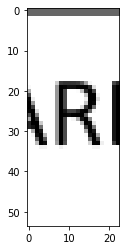

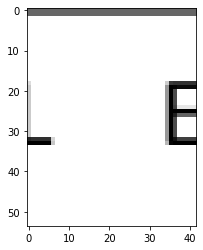

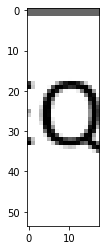

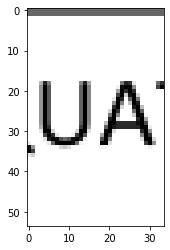

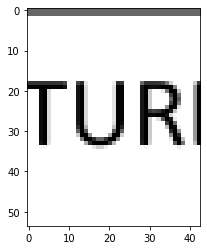

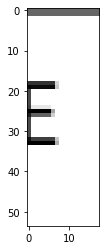

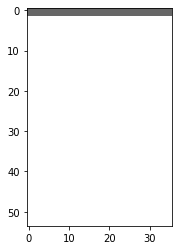

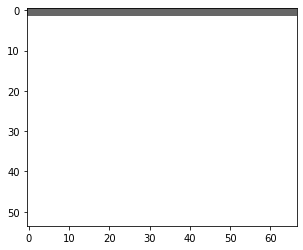

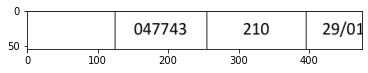

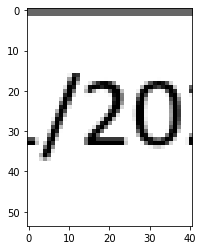

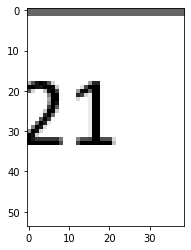

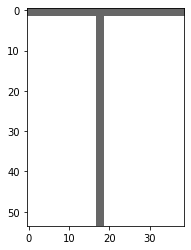

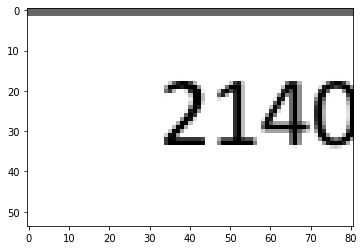

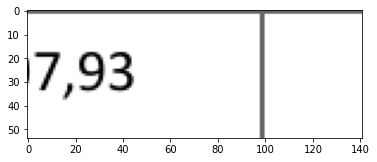

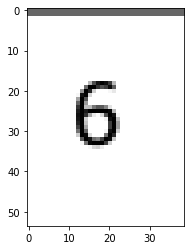

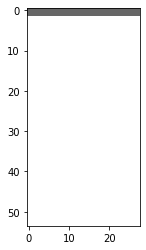

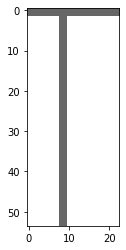

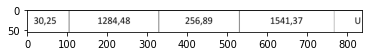

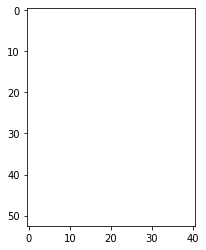

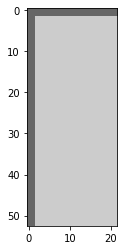

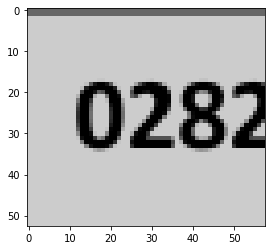

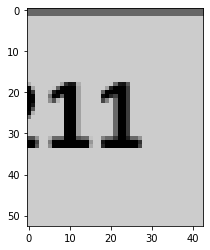

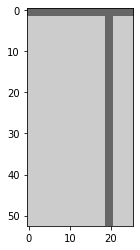

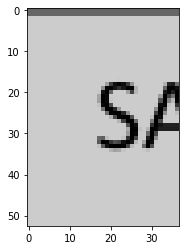

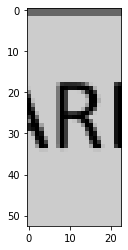

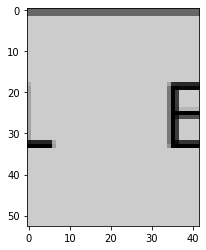

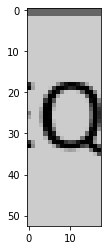

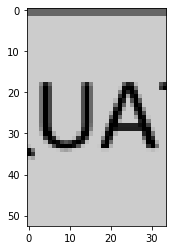

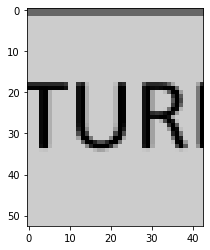

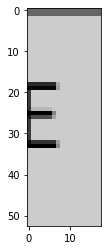

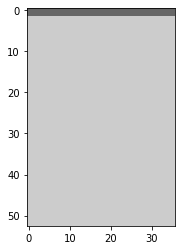

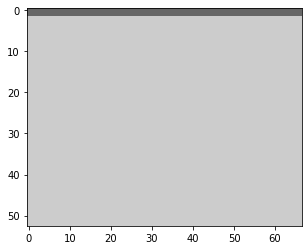

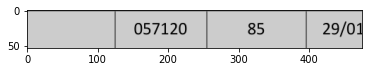

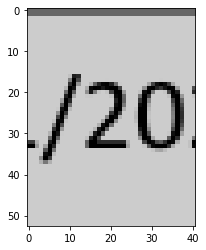

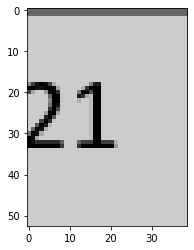

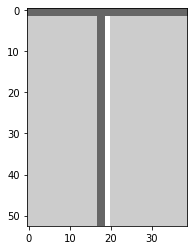

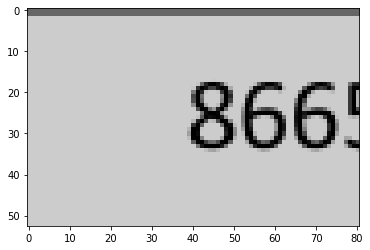

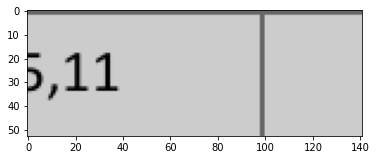

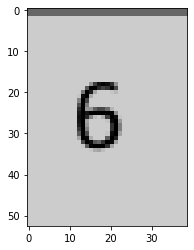

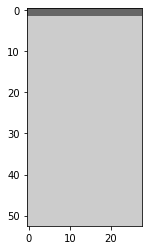

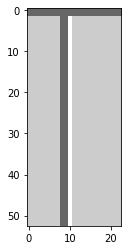

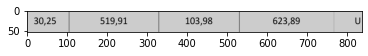

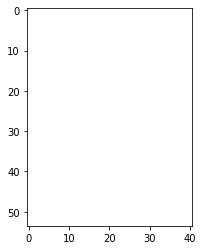

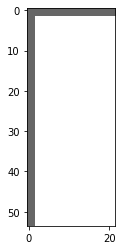

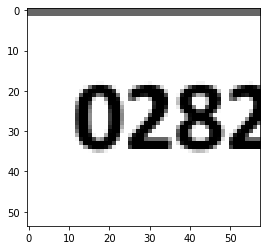

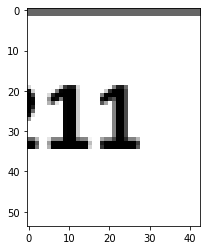

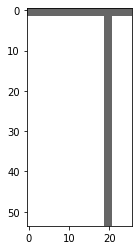

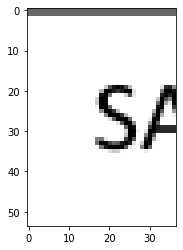

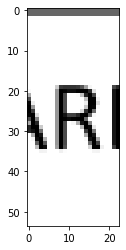

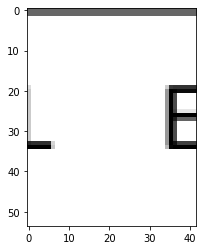

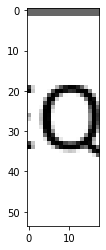

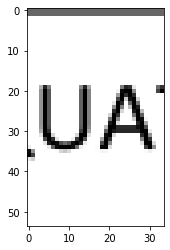

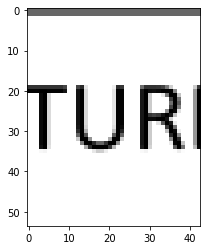

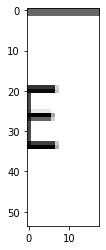

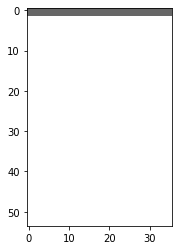

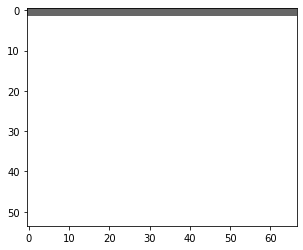

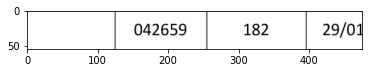

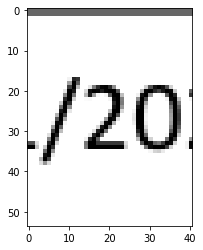

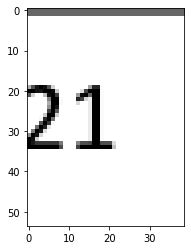

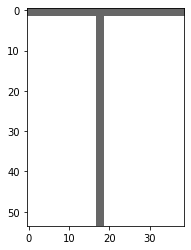

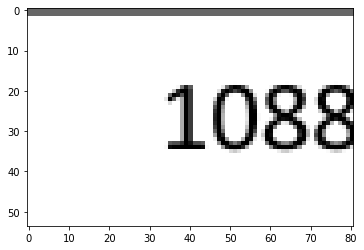

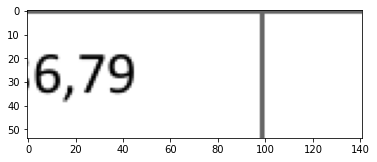

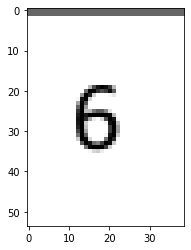

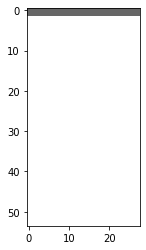

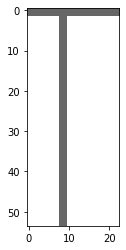

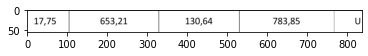

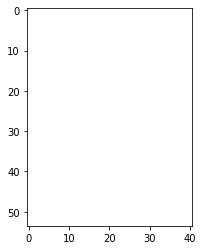

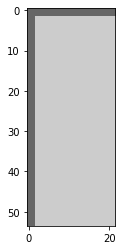

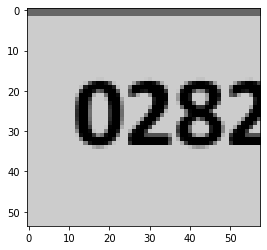

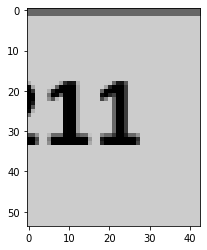

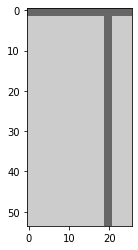

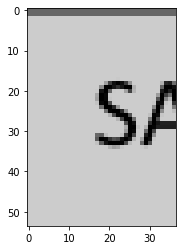

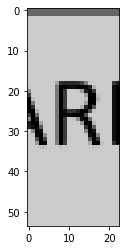

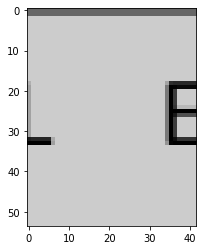

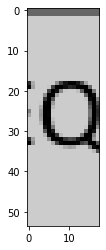

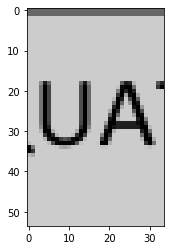

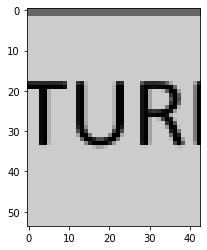

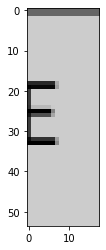

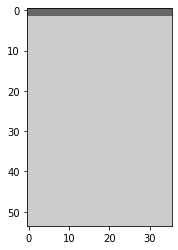

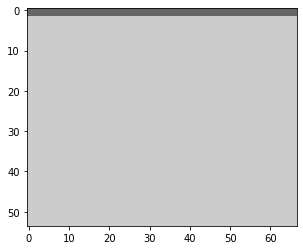

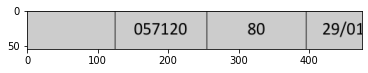

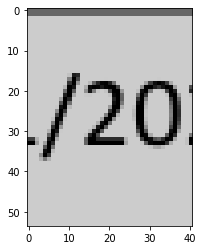

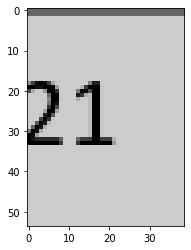

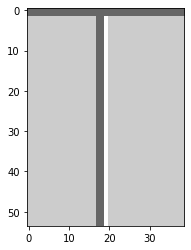

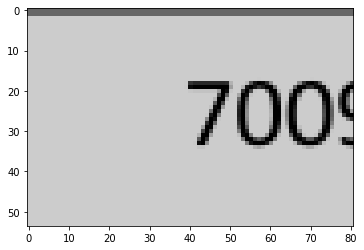

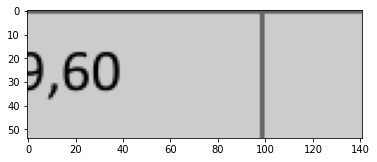

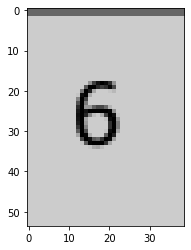

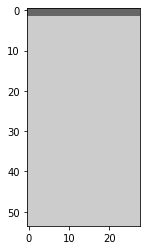

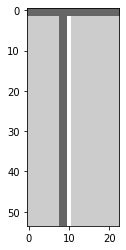

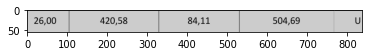

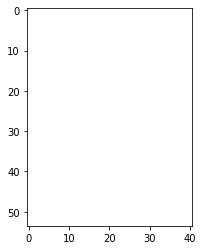

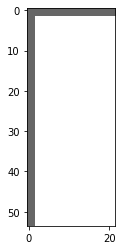

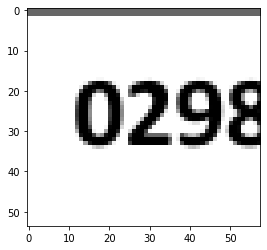

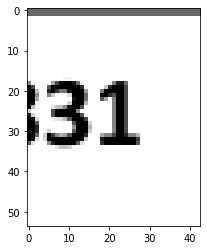

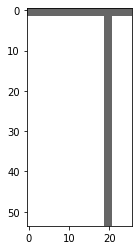

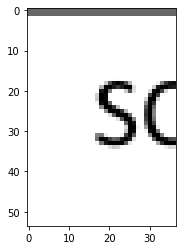

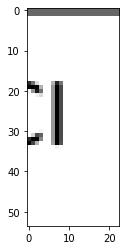

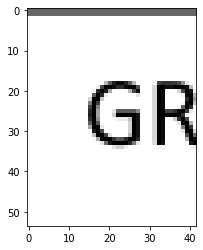

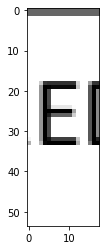

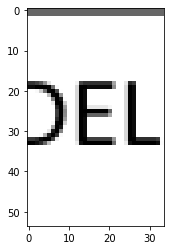

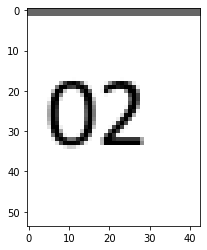

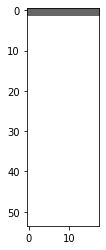

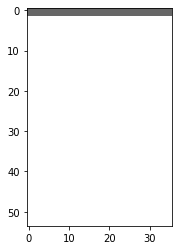

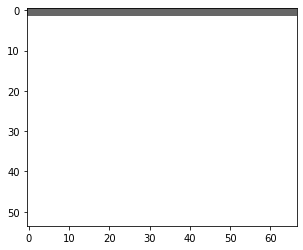

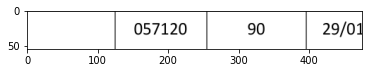

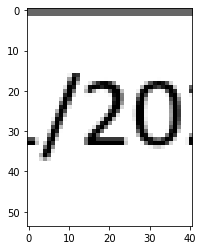

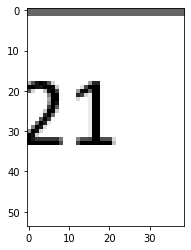

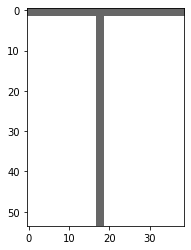

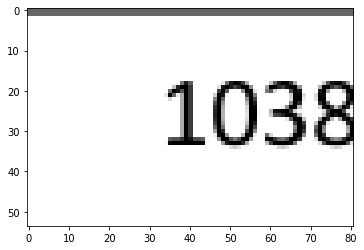

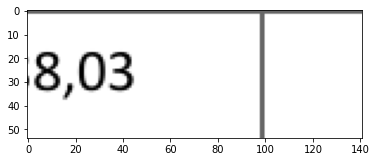

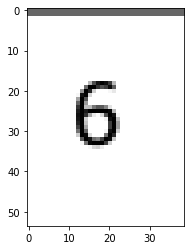

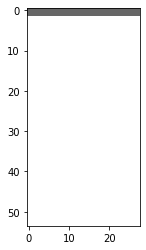

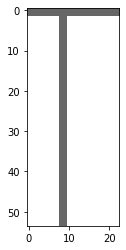

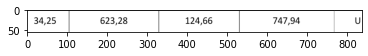

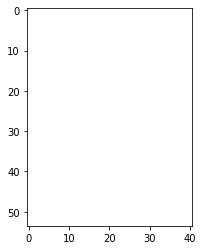

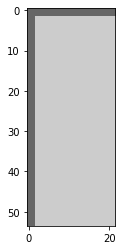

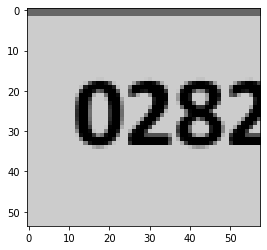

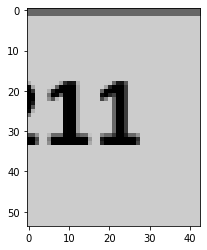

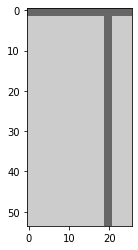

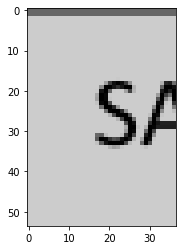

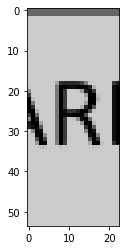

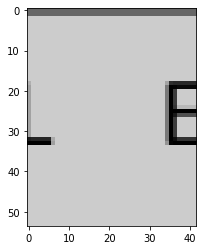

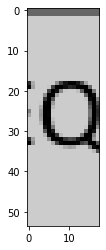

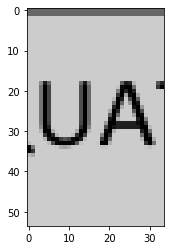

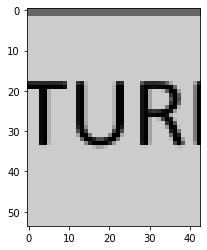

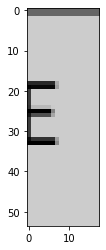

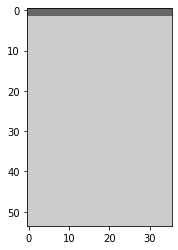

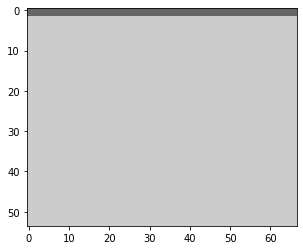

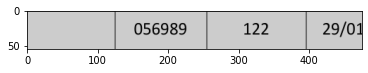

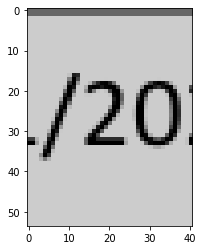

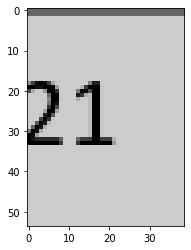

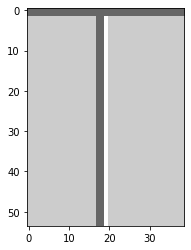

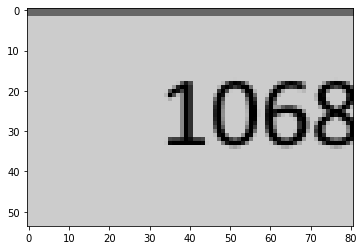

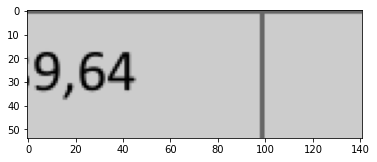

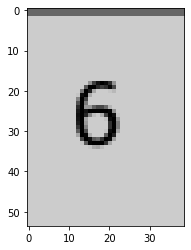

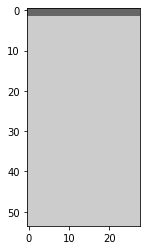

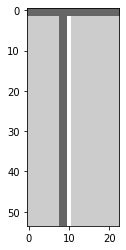

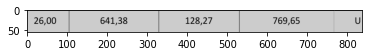

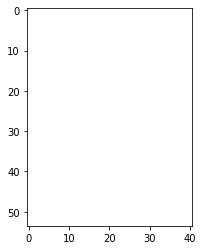

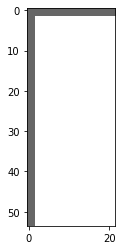

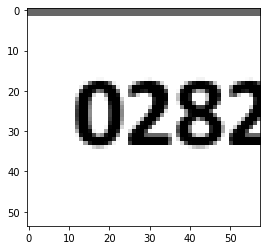

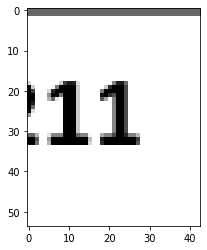

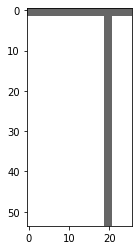

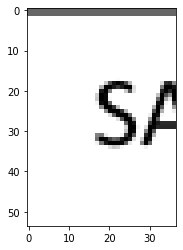

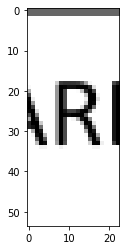

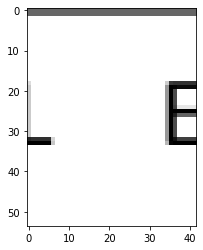

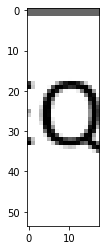

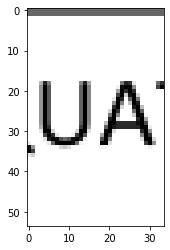

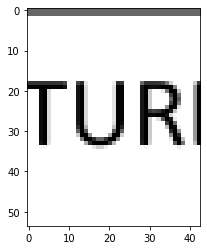

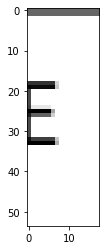

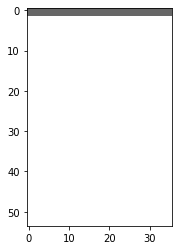

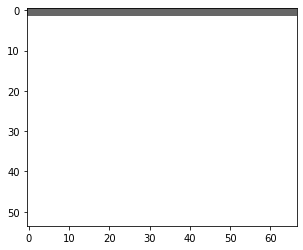

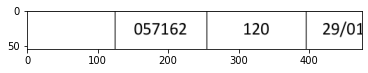

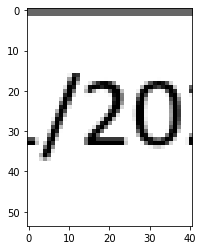

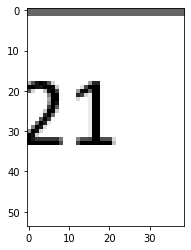

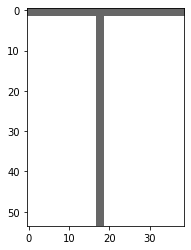

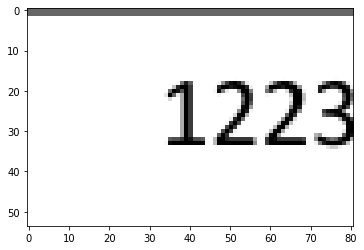

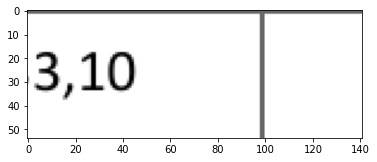

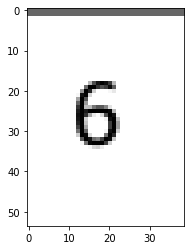

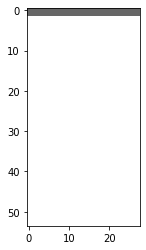

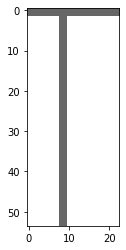

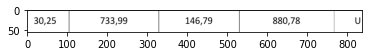

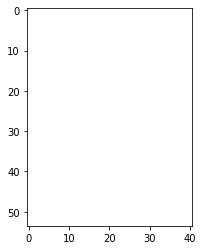

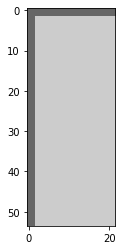

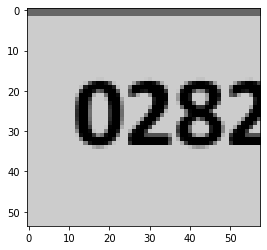

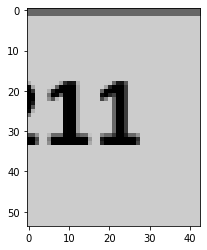

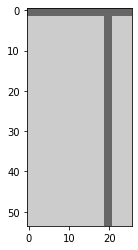

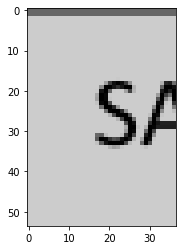

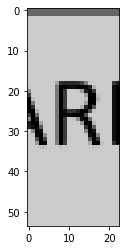

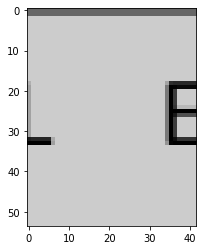

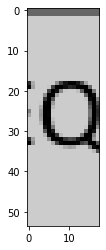

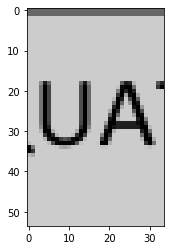

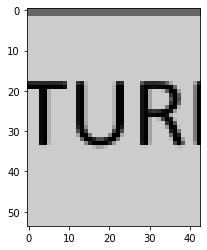

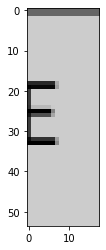

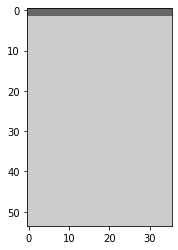

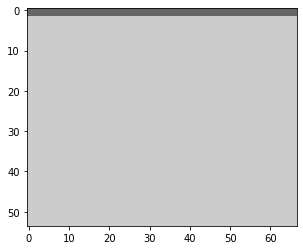

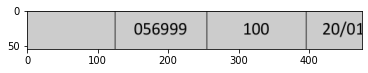

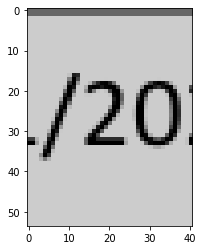

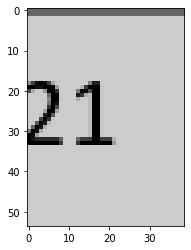

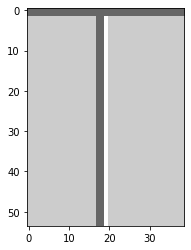

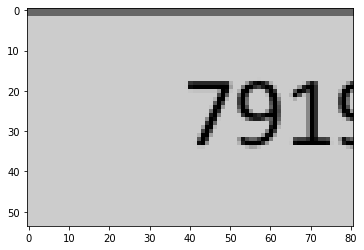

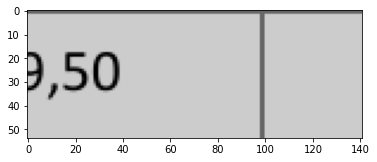

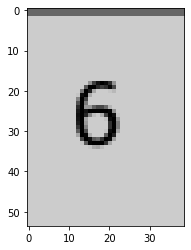

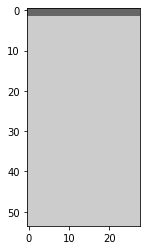

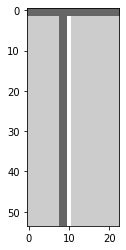

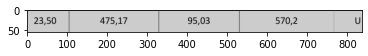

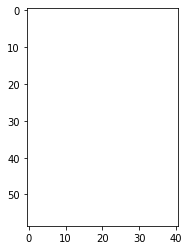

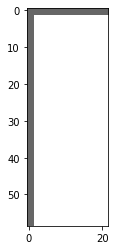

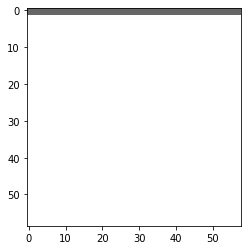

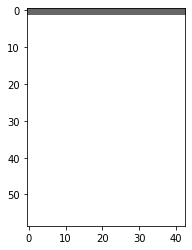

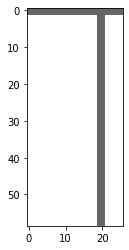

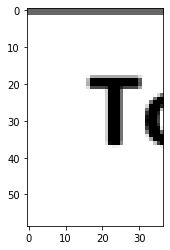

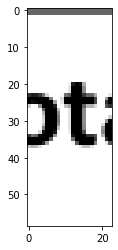

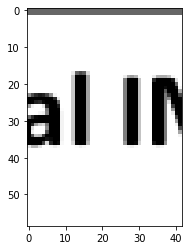

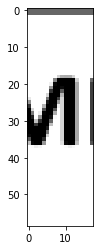

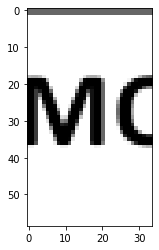

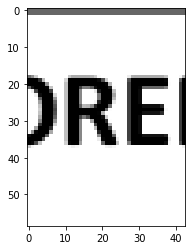

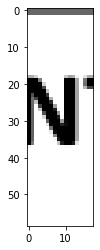

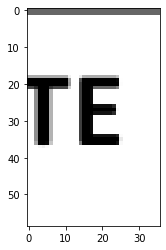

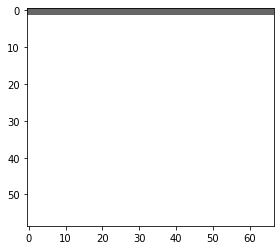

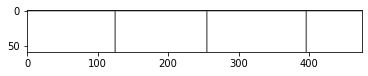

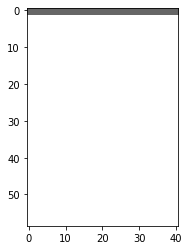

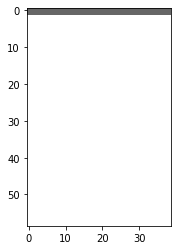

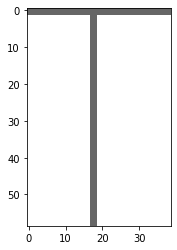

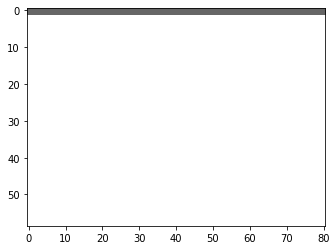

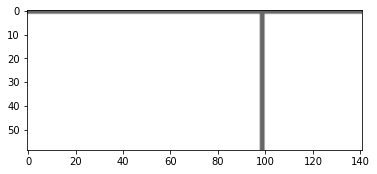

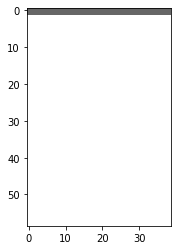

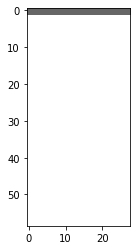

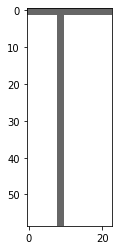

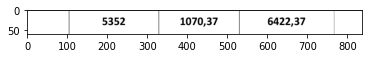

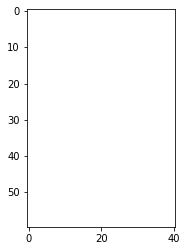

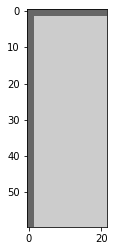

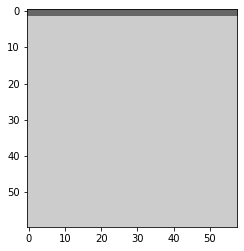

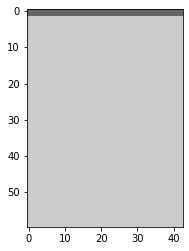

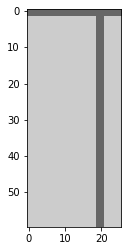

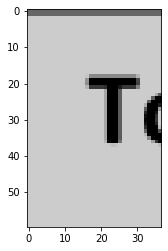

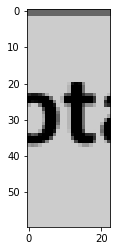

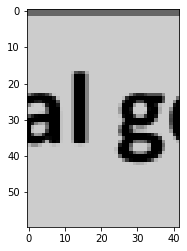

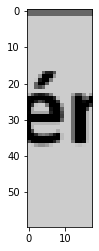

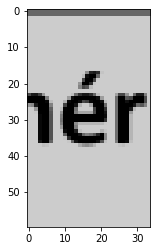

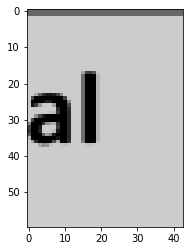

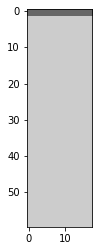

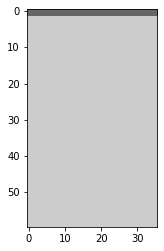

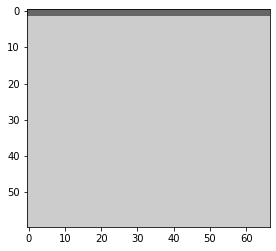

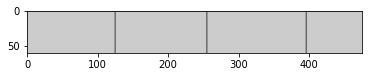

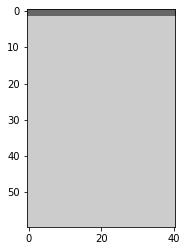

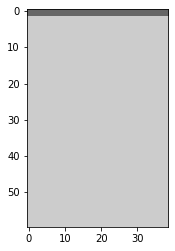

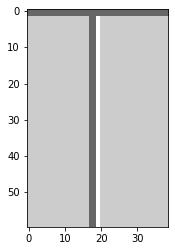

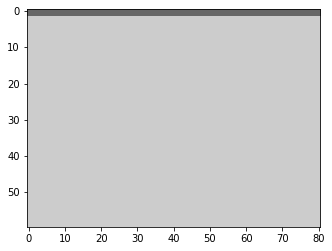

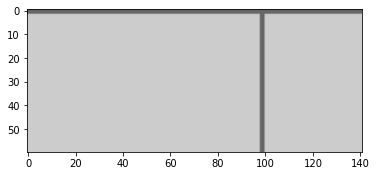

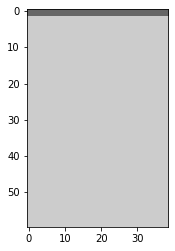

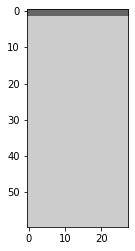

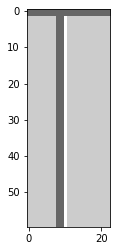

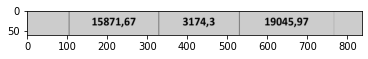

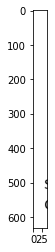

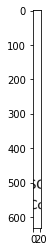

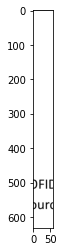

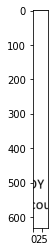

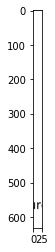

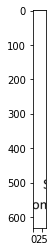

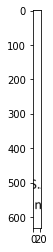

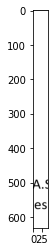

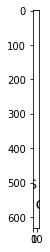

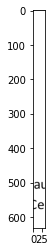

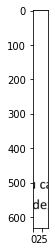

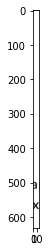

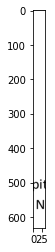

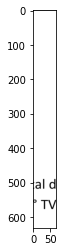

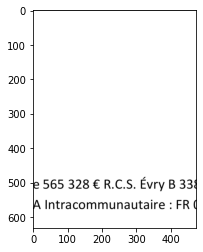

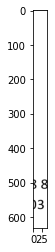

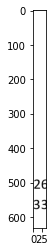

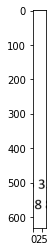

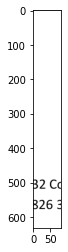

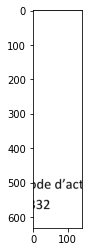

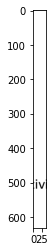

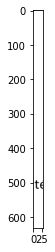

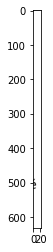

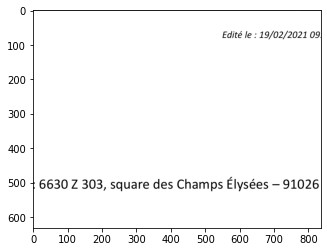

In [11]:
# Computing cells bounding boxes
cells = []

for y in range(len(yLines) - 1):
    tmp = []
    for x in range(len(xLines) - 1):
        tmp.append([xLines[x], yLines[y], xLines[x+1], yLines[y+1]])
    cells.append(tmp)

for i in cells:
    for j in i:
        plt.imshow(image[j[1]:j[3], j[0]:j[2]])
        plt.show()

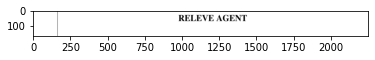

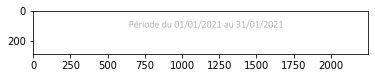

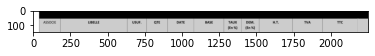

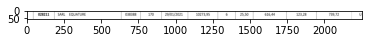

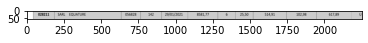

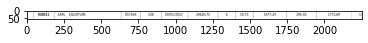

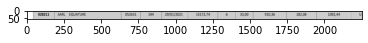

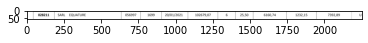

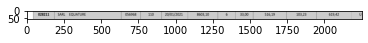

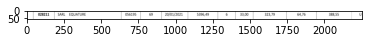

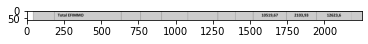

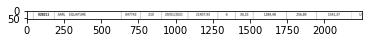

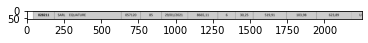

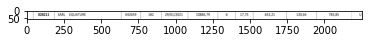

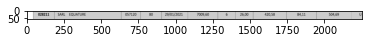

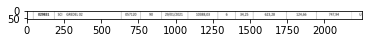

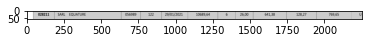

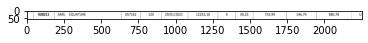

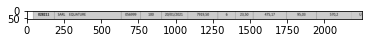

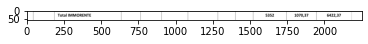

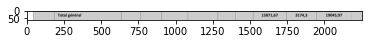

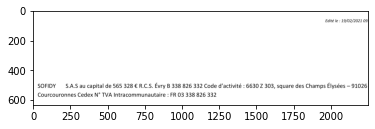

In [12]:
# Computing rows bounding boxes 
rows = []
for y in range(len(yLines) - 1):
    rows.append([xLines[0], yLines[y], xLines[-1], yLines[y+1]])

for i in rows:
    plt.imshow(image[i[1]:i[3], i[0]:i[2]])
    plt.show()
    
numberOfColumns = len(cells[0])

In [13]:
# Getting all the words positions, rects, and text using mmocr
mmocr = MMOCR(det='PS_CTW',kie = 'SDMGR')
details = mmocr.readtext(image, details=True, out_file=None)

load checkpoint from http path: https://download.openmmlab.com/mmocr/textdet/psenet/psenet_r50_fpnf_600e_ctw1500_20210401-216fed50.pth


/home/cvk/mmocr/mmocr/apis/inference.py:48: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


load checkpoint from http path: https://download.openmmlab.com/mmocr/textrecog/seg/seg_r31_1by16_fpnocr_academic-72235b11.pth
load checkpoint from http path: https://download.openmmlab.com/mmocr/kie/sdmgr/sdmgr_unet16_60e_wildreceipt_20210520-7489e6de.pth


/home/cvk/.local/lib/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/cvk/mmocr/mmocr/datasets/kie_dataset.py:43: UserWarning: KIEDataset is only initialized as a downstream demo task of text detection and recognition without an annotation file.
  warnings.warn(
/home/cvk/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/cvk/mmocr/mmocr/datasets/pipelines/box_utils.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, us

In [14]:
# centralize all the info we have and will compute into a List for every word detected
results = []
for element in details[0]['result']:
    x = 0
    y = 0
    xs = []
    ys = []
    for idx, i in enumerate(element['box']):
        if idx % 2 == 0:
            xs.append(i)
            x += i
        else:
            ys.append(i)
            y += i
            
    x = round(x / (len(element['box'])/2))
    y = round(y / (len(element['box'])/2))
    
    crop = image[min(ys):max(ys), min(xs):max(xs)]
    config = ("-l eng --oem 3 --psm 13")
    text = pytesseract.image_to_string(crop, config=config)
    
    xIndex = -1
    for xdx in range(len(xLines)-1):
        if x >= xLines[xdx] and x <= xLines[xdx+1]:
            xIndex = xdx
            break
    
    yIndex = -1
    for ydx in range(len(yLines)-1):
        if y >= yLines[ydx] and y <= yLines[ydx+1]:
            yIndex = ydx
            break
    
    results.append({
        'x': x, # x position of the center of the word
        'y': y, # y position of the center of the word
        'text': text.replace('|','').replace('\n',''), # text value of the word
        'xmin':min(xs), # word left side boundary (x value) 
        'xmax':max(xs), # word right side boundary (x value) 
        'ymin':min(ys), # word top side boundary (y value) 
        'ymax':max(ys), # word bottom side boundary (y value) 
        'xIndex':xIndex, # word x index in the grid layout 
        'yIndex':yIndex, # word y index in the grid layout 
    })

<IPython.core.display.Javascript object>


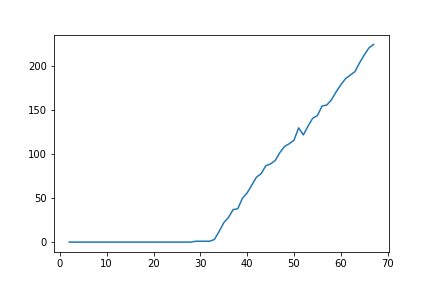

In [15]:
%matplotlib notebook

# Kmeans clustering to find the number and order of the rows


X = np.array([[y['y']] for y in results])
ax = []
ay = []

overlapList = []
ax = []

for c in range(2, len(results)//2):
    kmeans = KMeans(n_clusters=c, random_state=42).fit(X)
    centers = [i[0] for i in kmeans.cluster_centers_]
    
    labels = kmeans.labels_
    
    overlap = 0
    
    # Find overlapping element in clusters based on ymin and ymax for each word
    # Overlapping means that a word in a class is also crossed by an other class
    for idx, i in enumerate(centers):
        for jdx, j in enumerate(results):
            if labels[jdx] != idx:
                if i >= j['ymin'] and i <= j['ymax']:
                    overlap += 1
        
    overlapList.append(overlap)
    ax.append(c)
    
    
ax = np.array(ax)
ay = np.array(overlapList)

plt.plot(ax, ay)

In [16]:
def getError(reg, x, y):
    x = [i[0] for i in x]
    y = [i[0] for i in y]
    a = reg.coef_
    b = reg.intercept_
    rv = 0
    for idx, i in enumerate(x):
        rv += (a*i + b - y[idx])**2
    return rv    

In [17]:
# Compute the ideal number of clusters with a double sliding linear regression 

from sklearn.linear_model import LinearRegression
X = [[n] for n in range(len(ay))]
y = [[n] for n in ay]
maxScore = 0
yClusters = 0
for n in range(2, len(ay)-2):
    X1 = X[:n]
    y1 = y[:n]
    X2 = X[n:]
    y2 = X[n:]
    reg1 = LinearRegression().fit(X1, y1)
    reg2 = LinearRegression().fit(X2, y2)
    res = getError(reg1, X1, y1)[0][0] + getError(reg2, X2, y2)[0][0]
    if res > 10:
        yClusters = n
        break

In [18]:
# Now we use the previously calculated value for number of cluster about y values to get the word classified
X = np.array([[y['y']] for y in results])
kmeans = KMeans(n_clusters=yClusters, random_state=42).fit(X)

In [19]:
# add to the result array each word Y label
for ldx,label in enumerate(kmeans.labels_):
    results[ldx]['label'] = label

In [20]:
# Sort the Y clusters center
orderedCenters = [ (i[0], idx) for idx, i in enumerate(kmeans.cluster_centers_)]
orderedCenters.sort(key=lambda x:x[0])

In [21]:
# Create a dict which keys are corresponding to the yIndex for each word and the value is the y Classification
# of the words in this row
rowLabels = {}
for eldix, el in enumerate(rows):
    rowLabels[eldix] = [r[1] for r in orderedCenters if r[0] >= el[1] and r[0] <= el[3]]
rowLabels

{0: [9],
 1: [16],
 2: [14, 30],
 3: [2],
 4: [27],
 5: [13],
 6: [24],
 7: [10],
 8: [5],
 9: [17],
 10: [11],
 11: [26],
 12: [0],
 13: [12],
 14: [22],
 15: [7],
 16: [20],
 17: [8],
 18: [21],
 19: [3],
 20: [23],
 21: [18, 29, 4]}

In [22]:
# Fill the array with all the data at the right place
array = [['' for _ in range(numberOfColumns)] for _ in range(len(rows))]

for idx, i in enumerate(array):
    for jdx, j in enumerate(i):
        cellItems = [a for a in results if a['xIndex'] == jdx and a['yIndex'] == idx]
        cellResult = ''
        for labdx, label in enumerate(rowLabels[idx]):
            for item in cellItems:
                if item['label'] == label:
                    cellResult += f"{item['text']} " 
            
            cellResult += lineBreak if labdx < len(rowLabels[idx]) - 1 else ''
                
        array[idx][jdx] = cellResult
            

In [23]:
# Converting and saving to CSV file
pdResult = pd.DataFrame(np.array(array))
display(HTML(pdResult.to_html()))
pdResult.to_csv('test.csv', index=False, line_terminator=lineBreak)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,,,,,,,,,,,,,,,,,,,,RELEVE AGENT,,,,
1,,,,,,,,,,,,,,,,,,Période du 01/01/2021 au 31/01/2021,,,,,,
2,\n,\n,\n,~ASSOCIE \n,\n,\n,\n,\n,\n,\n,\n,\n,TIRELIT \n,\n,USUF. \n,\n,\n,\n,\n,\n,TAUX: \n(En %),\n,\n,\n(En %)
3,,,028211,,,,,,SARL EQUATURI,,,,,,038385,,,,"10273,95",,,,,"25,50 123,28 139,72"
4,,,,,,,,,,SARL EQUATURI,,,,,,29/01/2021,,,,,,,,
5,,,028211,,,,,,,SARL EQUATURE,,,,,05726¢,29/01/2021,,,,,,,,
6,,,NI2911,,,,CARI,,,—COVATIIPE,,,,,,90/01/9079:,,,,,,,,
7,,,028211,,,,,SARL EQUATURI,,,,,,,"ncEaQQ07 1600,",20/01/2021,,,1N9679 N7,,,,,"25,50 6160,74 -1232,15 7392,89"
8,,,0272711,,,,,SARL EQUATURI,,,,,,,OS6965 90/01/2072:,,,,2602 10,,,,,22 00 5616 1¢ 102 2: 619 A:
9,,,028711,,,,,SARL EQUATURI,,,,,,,056195 90/01/2021,,,,5396 49,,,,,"2200 2923 7C 64,76 388,55"
